In [64]:
%pip install pandas kagglehub[pandas-datasets] scikit-image matplotlib seaborn
%pip install tensorflow keras scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub

# folder
folder = "dataset"

# Download latest version
datapath = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print('dataset path: ' + datapath)

c:\Users\Davoleo\AppData\Local\Python\pythoncore-3.12-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset path: C:\Users\Davoleo\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


# Data preparation

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io as skio
from skimage import transform as skitrans

train = pd.read_csv(datapath + "\\Train.csv")
test = pd.read_csv(datapath + "\\Test.csv")

#print(train.describe())
#print(train.dtypes)

HEIGHT = 32
WIDTH = 32


def load_data(data_csv):

    ims = []
    classes = []

    for t in data_csv.itertuples(index=False):
        # Only use one size
        # if (not t.Path.endswith('00012.png')):
        #     continue

        impath = datapath + '\\' + t.Path
        
        fullim = skio.imread(impath)
        # plt.figure(1)
        # plt.subplot(1,3,1)
        # plt.imshow(fullim)

        # crop on: (Roi.X1, Roi.X2), (Roi.Y1, Roi.Y2)
        # print("crop: ", (t._2, t._4), (t._3, t._5))
        cropim = fullim[t._2:t._4, t._3:t._5]

        # plt.subplot(1,3,2)
        # plt.imshow(cropim)

        finalim = skitrans.resize(cropim, (WIDTH, HEIGHT))
        # plt.subplot(1,3,3)
        # plt.imshow(finalim)

        ims.append(finalim)
        classes.append(t.ClassId)
    
    return (ims, classes)


train_ims, train_class = load_data(train)
print("Training set loaded!!")
test_ims, test_class = load_data(test)
print("Test set loaded!!")


Training set loaded!!
Test set loaded!!


In [52]:
train_x = np.stack(train_ims, axis=0)
train_y = np.array(train_class)

test_x = np.stack(test_ims, axis=0)
test_y = np.array(test_class)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(39209, 32, 32, 3) (39209,)
(12630, 32, 32, 3) (12630,)


In [53]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

train_x = train_x.reshape(train_x.shape[0], HEIGHT*WIDTH*3)

train_x, train_y = shuffle(train_x, train_y, random_state=0)

print("Classes: ", np.unique(train_y))
# One-Hot Encoding
train_y = to_categorical(train_y)

train_x.shape

Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


(39209, 3072)

In [ ]:
from tensorflow.keras.utils import to_categorical

test_x = test_x.reshape(test_x.shape[0], HEIGHT*WIDTH*3)

print("Classes: ", np.unique(test_y))
hot_test_y = to_categorical(test_y)


test_x.shape

Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


(12630, 3072)

# Neural Network

In [56]:
from keras import Sequential
from keras.layers import Dense, Activation, Input
from keras import activations

model = Sequential()

model.add(Input((HEIGHT*WIDTH*3,)))
model.add(Dense(512, activation=activations.relu))
model.add(Dense(256, activation=activations.relu))
model.add(Dense(128, activation=activations.relu))
model.add(Dense(43, activation=activations.softmax))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,743,147 (6.65 MB)

 Trainable params: 1,743,147 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [58]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4372 - loss: 2.1671 - val_accuracy: 0.5594 - val_loss: 1.4972
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6918 - loss: 1.1027 - val_accuracy: 0.6964 - val_loss: 1.0504
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7789 - loss: 0.7938 - val_accuracy: 0.7469 - val_loss: 0.8952
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8148 - loss: 0.6499 - val_accuracy: 0.7793 - val_loss: 0.7778
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8522 - loss: 0.5316 - val_accuracy: 0.8184 - val_loss: 0.6822
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8652 - loss: 0.4760 - val_accuracy: 0.8625 - val_loss: 0.5103
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8846 - loss: 0.4007 - val_accuracy: 0.8528 - val_loss: 0.5190
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8994 - loss: 0.3488 - val_accu

In [59]:
import matplotlib.pyplot as plt

def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

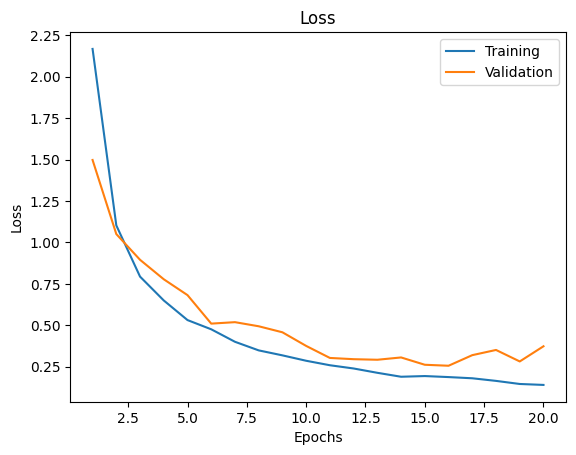

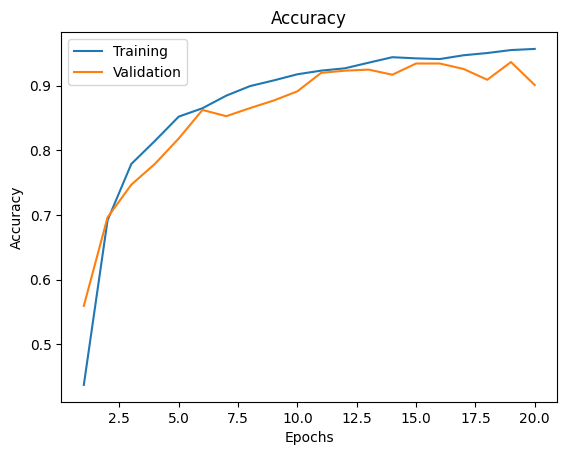

In [60]:
plot_loss(history)
plot_accuracy(history)

In [ ]:
loss, precision = model.evaluate(test_x, hot_test_y, verbose=1)

# Output Loss / Accuracy of the model after evaluating the model against the test set.
print("\n\nLoss: %6.4f\tAccuracy: %6.4f" % (loss, precision))


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8010 - loss: 1.2426


Loss: 1.2426	Accuracy: 0.8010


In [63]:
prediction = model.predict(test_x)
prediction

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[0.0000000e+00, 1.5168026e-35, 1.0108798e-33, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9744850e-30, 6.0285308e-15, 1.2399788e-14, ..., 3.1867496e-13,
        2.8539249e-18, 1.1421665e-19],
       [1.6813000e-28, 5.1042240e-19, 5.1831961e-09, ..., 5.4360527e-05,
        8.2106517e-13, 5.3611155e-25],
       ...,
       [1.7875104e-10, 1.0983785e-04, 6.5028129e-05, ..., 6.7535134e-06,
        9.4881676e-14, 6.0654010e-14],
       [0.0000000e+00, 0.0000000e+00, 8.8688633e-34, ..., 1.4744248e-37,
        0.0000000e+00, 0.0000000e+00],
       [2.5262268e-13, 2.1030765e-07, 1.2527444e-07, ..., 6.3725480e-08,
        7.8457157e-11, 1.9563372e-12]], shape=(12630, 43), dtype=float32)

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_predict = np.argmax(prediction, axis=1)

print(len(test_y), len(class_predict))
print("---------")
matrix = confusion_matrix(test_y, class_predict)
print(matrix)
print("---------")

# Confusion matrix heatmap
plt.figure(figsize=(20,20))
labels = np.unique(test_y)
ax=plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt=',d')
ax.set_xlabel("predicted labels")
ax.set_ylabel("true labels")
ax.set_title("confusion matrix")
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

print("salofa")